In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols

In [2]:
df = pd.read_csv('train.csv', sep=';')
df.head(n=5)

,Store_id,SKU_id,Date,Promo,Demand,Regular_Price,Promo_Price
0,1,1,01.01.2015,NaN,22,163.78,NaN
1,1,1,02.01.2015,NaN,41,163.78,NaN
2,1,1,03.01.2015,NaN,35,163.78,NaN
3,1,1,04.01.2015,NaN,72,163.78,NaN
4,1,1,05.01.2015,NaN,25,163.78,NaN


In [3]:
def transform(x, ttype):
    '''
    Accepts vector and performs transformation on it based on ttype
    '''
    if ttype == 'log':
        return np.log1p(x)
    
    return np.array(x)

In [4]:
def coef(model):
    """
    return regression coefficient of model
    """
    return model.params[1] if len(model.params) > 1 else model.params[0]

def pvalue(model):
    """
    return regression coefficient's t-test p-value of model
    """
    return model.pvalues[1] if len(model.pvalues) > 1 else model.pvalues[0]

In [5]:
def elasticity(X, y, model, model_type):
    '''
    Computes elasticity of model based on X, y, model itself and model's type
    '''
    if model_type == 'lin-lin':
        return coef(model) * np.mean(X) / np.mean(y)
    elif model_type == 'log-lin':
        return coef(model) * np.mean(X)
    elif model_type == 'log-log':
        return coef(model)

In [6]:
def PEDmodel(X, y, model_type='lin-lin'):
    '''
    Makes PED model based on input data X, y and model type
    '''
    _types = model_type.split('-')
    
    act_x = transform(X, _types[1])
    act_x = sm.add_constant(act_x)
    
    act_y = transform(y, _types[0])
    
    return sm.OLS(act_y, act_x).fit()

In [7]:
def get_model_stats(X, y, model, model_type):
    '''
    returns model's statistics
        regression coefficient,
        R-squared,
        T-test p-value,
        elasticity
    '''
    elas = elasticity(X, y, model, model_type)
    
    return coef(model), model.rsquared, pvalue(model), elas

In [44]:
def GeneratePEDModels(
    dataset,
    sample=None
):
    all_model_types = ['lin-lin', 'log-lin', 'log-log']
    sku_id, store_id, coeff, rsquared, ttpvalue, elas, mtype = [], [], [], [], [], [], []
    qty = []
    
    for shop_id in dataset.Store_id.unique():
        for good_id in dataset.SKU_id.unique():
            data = dataset[(dataset.Store_id == shop_id) & (dataset.SKU_id == good_id)]
            if sample is not None:
                data = data.sample(n=min(sample, data.shape[0]))
            
            curQty = data.Demand.sum()
            for model_type in all_model_types:
                model = PEDmodel(data.Regular_Price, data.Demand, model_type)

                c, r2, tp, e = get_model_stats(data.Regular_Price, data.Demand, model, model_type)

                sku_id.append(good_id)
                store_id.append(shop_id)
                coeff.append(c)
                rsquared.append(r2)
                ttpvalue.append(tp)
                elas.append(e)
                mtype.append(model_type)
                qty.append(curQty)
    
    return pd.DataFrame({
        'SKU': sku_id,
        'Store': store_id,
        'Coefficient': coeff,
        'R-squared': rsquared,
        'T-test-p-value': ttpvalue,
        'Model-type': mtype,
        'Elasticity': elas,
        'Qty': qty
    })

In [55]:
def PEDModelsStats(
    stats,
    adequate_elasticity=(-10, 0),
    adequate_p_value=(0, 0.05),
    all_model_types=['lin-lin', 'log-lin', 'log-log']
):
    elasticity_min, elasticity_max = adequate_elasticity
    p_value_min, p_value_max = adequate_p_value
    
    result = pd.DataFrame()
    result['ModelType'] = all_model_types

    percents_id = []
    percents_qty = []
    percents_oadeq = []
    
    for model_type in all_model_types:
        stats_model_type = stats[stats['Model-type'] == model_type]

        stats_attrs = stats_model_type[
            (stats_model_type.Elasticity >= elasticity_min) &
            (stats_model_type.Elasticity <= elasticity_max)
        ]
        
        percents_oadeq.append(round(stats_attrs.Qty.sum() / stats_model_type.Qty.sum(), 2))
        
        stats_attrs = stats_attrs[
            (stats_attrs['T-test-p-value'] >= p_value_min) &
            (stats_attrs['T-test-p-value'] <= p_value_max)
        ]

        percents_id.append(round(stats_attrs.shape[0] / stats_model_type.shape[0], 2))
        percents_qty.append(round(stats_attrs.Qty.sum() / stats_model_type.Qty.sum(), 2))

    percents_id = [f'{int(p * 100)}%' for p in percents_id]
    percents_qty = [f'{int(p * 100)}%' for p in percents_qty]
    percents_oadeq = [f'{int(p * 100)}%' for p in percents_oadeq]
    
    
    result['Адекватные и стат. значимые % SKU'] = percents_id
    result['Адекватные и стат. значимые % Qty'] = percents_qty
    result['Адекватные % Qty'] = percents_oadeq

    
    return result

In [56]:
PEDModelsStats(GeneratePEDModels(df))

,ModelType,Адекватные и стат. значимые % SKU,Адекватные и стат. значимые % Qty,Адекватные % Qty
0,lin-lin,71%,92%,98%
1,log-lin,74%,93%,99%
2,log-log,74%,93%,99%


In [181]:
def PlotSampleSizeElasticityRelation(
    data,
    all_model_types=['lin-lin', 'log-lin', 'log-log']
):    
    _, popular_store_id, popular_sku_id = max(
        (data[(data.Store_id == store_id) & (data.SKU_id == sku_id)].shape[0], store_id, sku_id)
        for store_id in data.Store_id.unique()
        for sku_id in data.SKU_id.unique()
    )
    
    stats = data[(data.Store_id == popular_store_id) & (data.SKU_id == popular_sku_id)]
    sizes = np.linspace(10, stats.shape[0], num=30, dtype=int)
    
    resulting_stats = {model_type: [] for model_type in all_model_types}
    
    # calculating stats
    for current_size in sizes:
        for model_type in all_model_types:
            sampled = stats.sample(n=current_size)
            ped_model = PEDmodel(sampled.Regular_Price, sampled.Demand, model_type)
            _, _, _, elas = get_model_stats(sampled.Regular_Price, sampled.Demand, ped_model, model_type)
            
            resulting_stats[model_type].append(elas)

    # plotting
    plt.figure(figsize=(14, 8))
    for model_type in all_model_types:
        plt.plot(sizes, resulting_stats[model_type], label=model_type)
    plt.ylabel('Эластичность')
    plt.xlabel('Размер сэмпла')
    plt.legend()

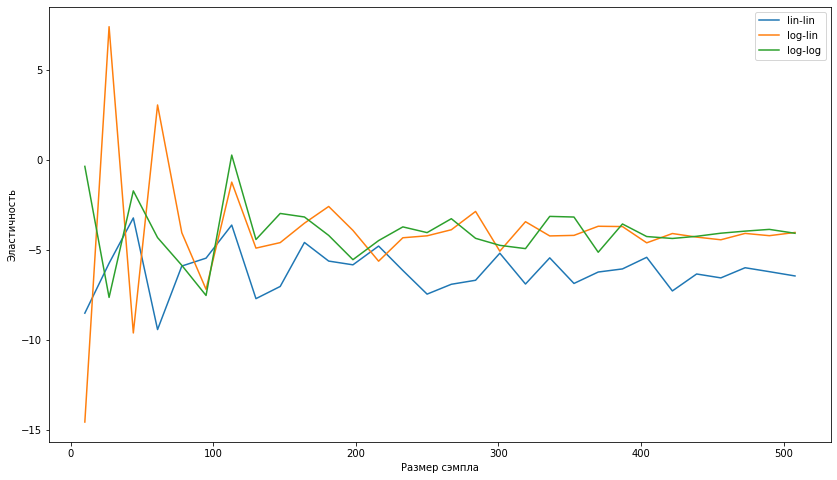

In [182]:
PlotSampleSizeElasticityRelation(df)

Чем больше размер сэмпла, тем лучше сходимость эластичности

In [53]:
def PlotSampleSizeAdequaticityRelation(
    data,
    model_type='lin-lin'
):    
    _, popular_store_id, popular_sku_id = max(
        (data[(data.Store_id == store_id) & (data.SKU_id == sku_id)].shape[0], store_id, sku_id)
        for store_id in data.Store_id.unique()
        for sku_id in data.SKU_id.unique()
    )
    
    tmp = data[(data.Store_id == popular_store_id) & (data.SKU_id == popular_sku_id)]
    sizes = np.linspace(20, tmp.shape[0], num=5, dtype=int)
    resulting_stats = {}
    
    def apply_stat(stat_name, stat_value):
        if stat_name not in resulting_stats:
            resulting_stats[stat_name] = []
        resulting_stats[stat_name].append(stat_value)
    
    # calculating stats
    for current_size in sizes:
        #print(current_size)
        stats = PEDModelsStats(GeneratePEDModels(data, sample=current_size), all_model_types=[model_type])
        
        for stat_name in stats.columns:
            if stat_name == 'ModelType':
                continue
            stat_value = stats.loc[0, stat_name]
            stat_value = float(stat_value.rstrip('%')) / 100
            
            apply_stat(stat_name, stat_value)

    # plotting
    plt.figure(figsize=(16, 9))
    for stat_name in resulting_stats:
        plt.plot(sizes, resulting_stats[stat_name], label=stat_name)
    plt.xlabel('Размер сэмпла')
    plt.legend()

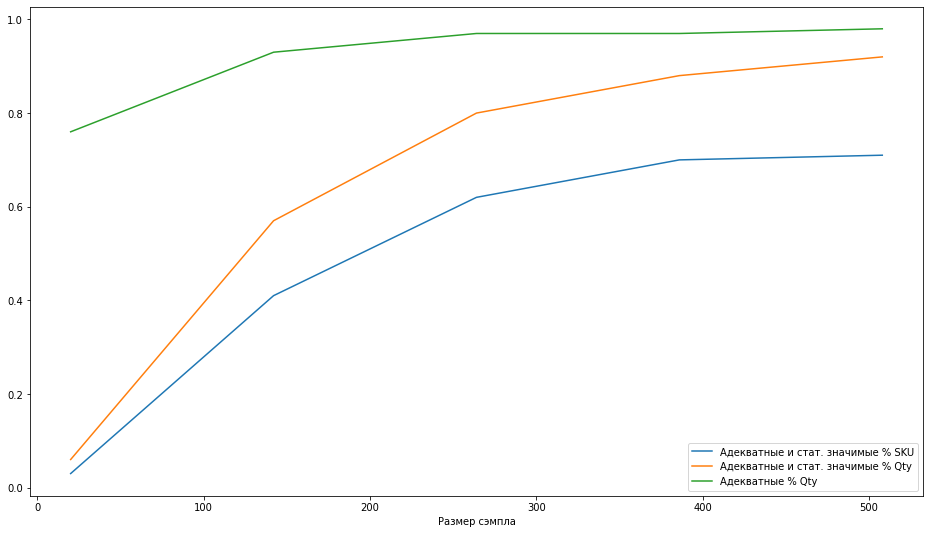

In [54]:
PlotSampleSizeAdequaticityRelation(df)